In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm

from src.VAE import LinearVAE

In [6]:
encoder0 = nn.Sequential(nn.Linear(28 * 28, 256),
                         nn.ReLU(),
                         nn.Linear(256, 128),
                         nn.ReLU())
decoder0 = nn.Sequential(nn.Linear(64, 128),
                         nn.ReLU(),
                         nn.Linear(128, 256),
                         nn.ReLU(),
                         nn.Linear(256, 28 * 28),
                         nn.Sigmoid())

In [7]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [8]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

## Only BCE

In [9]:
model = LinearVAE(encoder0, decoder0, 128, 64).cuda()
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [6]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu, log_var = model(data)
            reconLoss = BCE(output, data)
            loss = reconLoss
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTotal Loss: {:.6f}\tReconstruction Loss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allLoss, allReconLoss

In [7]:
for epoch in range(1, 201):
    _, loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

100%|██████████| 59/59 [00:04<00:00, 11.99batch/s,  Epoch: 200 	Total Loss: 0.085919	Reconstruction Loss: 0.085919	 lr: 10.00000000]


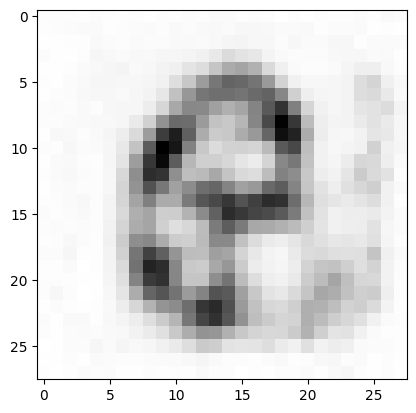

In [8]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')

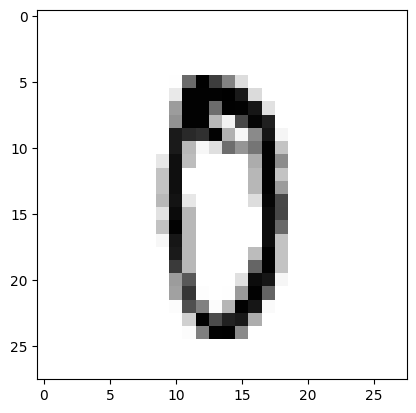

In [22]:
img0 = next(iter(train_loader))[0][99]
plt.imshow(img0[0], cmap='Greys')

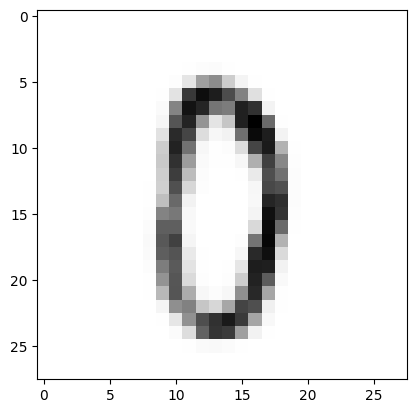

In [23]:
output, mu, log_var = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')

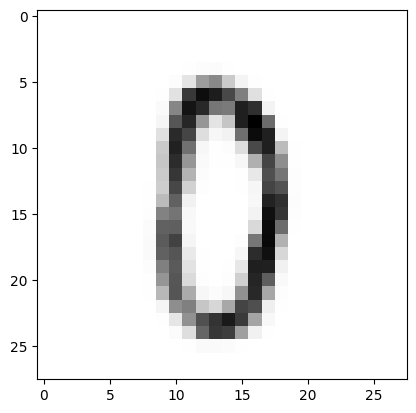

In [24]:
output, mu, log_var = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(model.sample(mu).cpu().detach().view(28, 28), cmap='Greys')

In [19]:
mms = MinMaxScaler()
mms01 = mms.fit_transform(mu.detach().cpu().numpy().T)

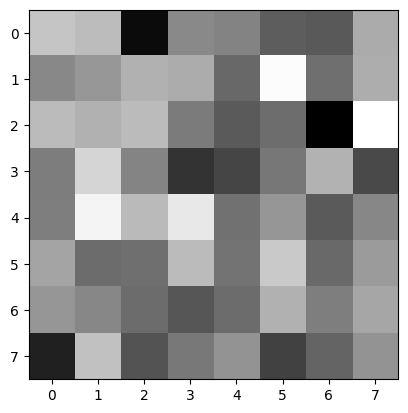

In [20]:
plt.imshow(mms01.reshape(8, 8), cmap='Greys')

In [21]:
torch.save(model.state_dict(), 'regVAE00_200epochs')

### model 1

In [15]:
model.load_state_dict(torch.load('regVAE00_200epochs'))

<All keys matched successfully>

In [18]:
encoder1 = nn.Sequential(nn.Linear(64, 64),
                         nn.ReLU(),
                         nn.Linear(64, 32),
                         nn.ReLU())
decoder1 = nn.Sequential(nn.Linear(16, 32),
                         nn.ReLU(),
                         nn.Linear(32, 64),
                         nn.ReLU(),
                         nn.Linear(64, 64))
model1 = LinearVAE(encoder1, decoder1, 32, 16).cuda()
optimizer = optim.Adadelta(model1.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [19]:
def train1(net, train_loader, optimizer, epoch):
    net.train()
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            _, interOutput, _ = model(data)
            output, _, _ = net(interOutput.detach())
            reconLoss = L1Loss(output, interOutput)
            reconLoss.backward()
            optimizer.step()
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tReconstruction Loss: {:.6f}\t lr: {:.8f}'.format(
                epoch, reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allReconLoss

In [20]:
for epoch in range(1, 201):
    loss = train1(model1, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

100%|██████████| 59/59 [00:04<00:00, 12.44batch/s,  Epoch: 200 	Reconstruction Loss: 0.930519	 lr: 0.10000000]


In [21]:
for epoch in range(201, 301):
    loss = train1(model1, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

100%|██████████| 59/59 [00:05<00:00, 11.55batch/s,  Epoch: 300 	Reconstruction Loss: 0.904941	 lr: 0.10000000]


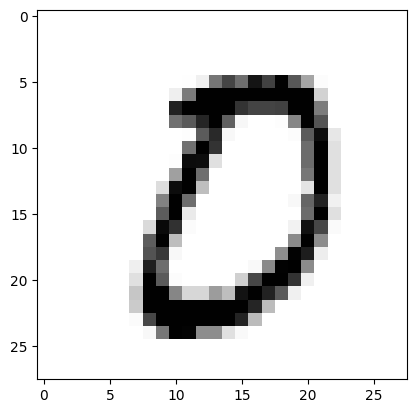

In [25]:
img0 = next(iter(train_loader))[0][99]
plt.imshow(img0[0], cmap='Greys')

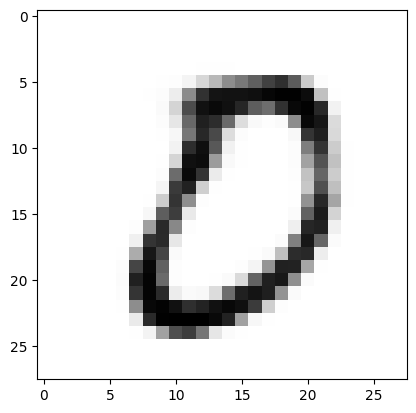

In [31]:
output, mu, log_var = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')

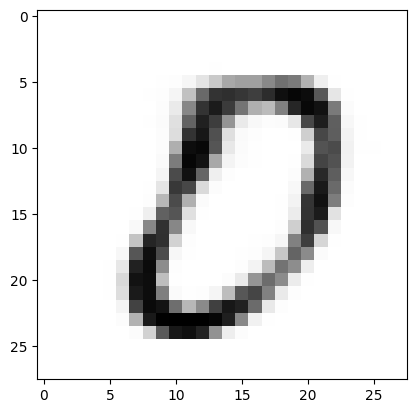

In [32]:
_, interOutput, _ = model(img0.view(-1, 28 * 28).cuda())
output, mu, log_var = model1(interOutput)
plt.imshow(model.sample(output).cpu().detach().view(28, 28), cmap='Greys')

In [33]:
mu

tensor([[ 2.7183e-02,  8.6011e+00,  8.4348e+00,  4.0580e+00, -3.1790e+00,
         -1.2977e+01,  2.4694e+01, -1.2136e+01,  2.4074e+00,  7.1473e+00,
          1.9952e+00,  2.9003e+01, -3.6338e-01,  7.2282e-01, -4.3633e+00,
          5.2911e+00]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [34]:
log_var

tensor([[-25.7693, -23.5371, -30.4626, -28.6531, -29.5610, -32.2796, -32.6819,
         -29.9182, -27.5484, -31.4930, -28.7216, -25.5644, -31.8688, -30.8862,
         -27.0919, -30.4480]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [35]:
torch.save(model1.state_dict(),'regVAE01_200epoch')

### model2

In [ ]:
model2=